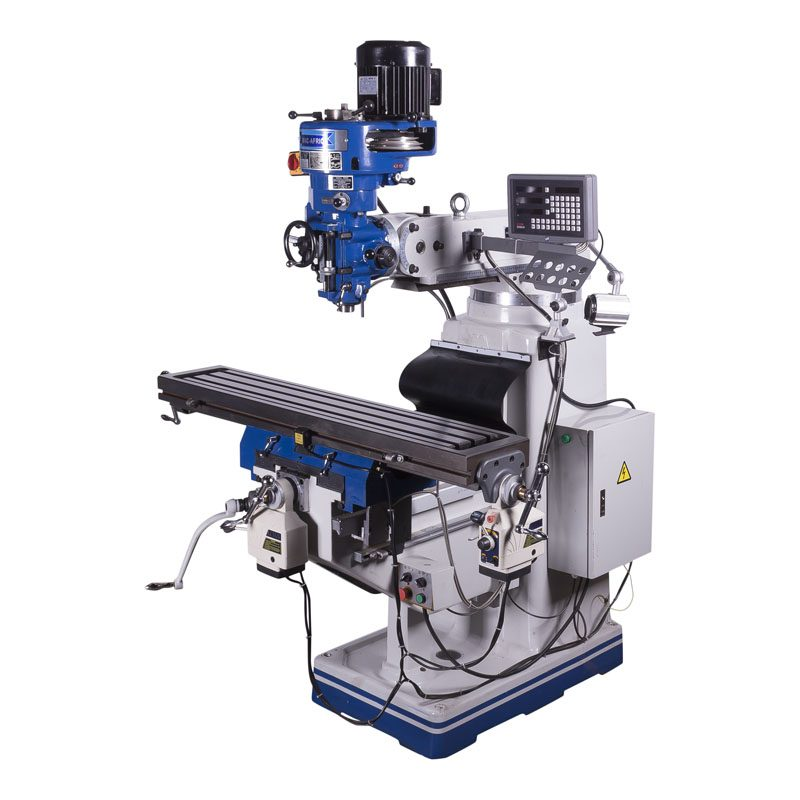

This synthetic dataset is modeled after an existing milling machine and consists of 10,000 data points stored as rows with 14 features in columns:

* **UID**: unique identifier ranging from 1 to 10000.

* **product ID**: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number.

* **type**: just the product type L, M or H from column 2.

* **air temperature [K]**: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K.

* **process temperature [K]**: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.

* **rotational speed [rpm]**: calculated from a power of 2860 W, overlaid with a normally distributed noise.

* **torque [Nm]**: torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values. 8.tool wear [min]: (breakdown and gradual failure of a cutting tool due to regular operation) The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.

* **'machine failure** : indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true. The machine failure consists of five independent failure modes:

# Install and Import Spark in Colab:

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
# Initialize Spark session
spark = SparkSession.builder.appName("PredictiveMaintenance").getOrCreate()

# Upload Dataset to Google Colab

In [ ]:
df= spark.read.csv("ai4i2020.csv", header=True, inferSchema=True)
df

DataFrame[UDI: int, Product ID: string, Type: string, Air temperature [K]: double, Process temperature [K]: double, Rotational speed [rpm]: int, Torque [Nm]: double, Tool wear [min]: int, Machine failure: int, TWF: int, HDF: int, PWF: int, OSF: int, RNF: int]

# Data Exploration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, when, lit, trim
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import KMeans,  GaussianMixture, BisectingKMeans
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler, SQLTransformer
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import SparkSession, functions as F
from yellowbrick.cluster import KElbowVisualizer
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from pyspark.ml.classification import (
    DecisionTreeClassifier,
    RandomForestClassifier,
    GBTClassifier,
    LogisticRegression,
    LinearSVC,
    MultilayerPerceptronClassifier,
)
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import time


In [ ]:
df.printSchema()

root
 |-- UDI: integer (nullable = true)
 |-- Product ID: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Air temperature [K]: double (nullable = true)
 |-- Process temperature [K]: double (nullable = true)
 |-- Rotational speed [rpm]: integer (nullable = true)
 |-- Torque [Nm]: double (nullable = true)
 |-- Tool wear [min]: integer (nullable = true)
 |-- Machine failure: integer (nullable = true)
 |-- TWF: integer (nullable = true)
 |-- HDF: integer (nullable = true)
 |-- PWF: integer (nullable = true)
 |-- OSF: integer (nullable = true)
 |-- RNF: integer (nullable = true)



In [ ]:
df.show(5)

+---+----------+----+-------------------+-----------------------+----------------------+-----------+---------------+---------------+---+---+---+---+---+
|UDI|Product ID|Type|Air temperature [K]|Process temperature [K]|Rotational speed [rpm]|Torque [Nm]|Tool wear [min]|Machine failure|TWF|HDF|PWF|OSF|RNF|
+---+----------+----+-------------------+-----------------------+----------------------+-----------+---------------+---------------+---+---+---+---+---+
|  1|    M14860|   M|              298.1|                  308.6|                  1551|       42.8|              0|              0|  0|  0|  0|  0|  0|
|  2|    L47181|   L|              298.2|                  308.7|                  1408|       46.3|              3|              0|  0|  0|  0|  0|  0|
|  3|    L47182|   L|              298.1|                  308.5|                  1498|       49.4|              5|              0|  0|  0|  0|  0|  0|
|  4|    L47183|   L|              298.2|                  308.6|                 

In [ ]:
# Drop 'UDI' and 'Product ID' columns
columns_to_drop = ['Product ID', 'UDI']
df = df.drop(*columns_to_drop)
# Rename columns
df = df.withColumnRenamed('Air temperature [K]', 'Air temperature') \
        .withColumnRenamed('Process temperature [K]', 'Process temperature') \
        .withColumnRenamed('Rotational speed [rpm]', 'Rotational speed') \
        .withColumnRenamed('Torque [Nm]', 'Torque') \
        .withColumnRenamed('Tool wear [min]', 'Tool wear')
# Show the first 5 rows of the DataFrame
df.show(5)

+----+---------------+-------------------+----------------+------+---------+---------------+---+---+---+---+---+
|Type|Air temperature|Process temperature|Rotational speed|Torque|Tool wear|Machine failure|TWF|HDF|PWF|OSF|RNF|
+----+---------------+-------------------+----------------+------+---------+---------------+---+---+---+---+---+
|   M|          298.1|              308.6|            1551|  42.8|        0|              0|  0|  0|  0|  0|  0|
|   L|          298.2|              308.7|            1408|  46.3|        3|              0|  0|  0|  0|  0|  0|
|   L|          298.1|              308.5|            1498|  49.4|        5|              0|  0|  0|  0|  0|  0|
|   L|          298.2|              308.6|            1433|  39.5|        7|              0|  0|  0|  0|  0|  0|
|   L|          298.2|              308.7|            1408|  40.0|        9|              0|  0|  0|  0|  0|  0|
+----+---------------+-------------------+----------------+------+---------+---------------+---+

In [ ]:
# Select numeric columns
numeric_cols = [col_name for col_name, col_type in df.dtypes if col_type in ['int', 'double']]

# Select and display descriptive statistics for numeric columns
df.select(numeric_cols).describe().show(truncate=False)

+-------+------------------+-------------------+------------------+------------------+-----------------+-----------------+-------------------+-------------------+-------------------+------------------+-------------------+
|summary|Air temperature   |Process temperature|Rotational speed  |Torque            |Tool wear        |Machine failure  |TWF                |HDF                |PWF                |OSF               |RNF                |
+-------+------------------+-------------------+------------------+------------------+-----------------+-----------------+-------------------+-------------------+-------------------+------------------+-------------------+
|count  |10000             |10000              |10000             |10000             |10000            |10000            |10000              |10000              |10000              |10000             |10000              |
|mean   |300.00492999999875|310.00555999999995 |1538.7761         |39.986909999999995|107.951          |0.0339  

In [ ]:
# Select categorical columns
categorical_cols = [col_name for col_name, col_type in df.dtypes if col_type == 'string']

# Display counts of unique values for each categorical column
for col in categorical_cols:
    print(f"Column: {col}")
    df.groupBy(col).count().show(truncate=False)


Column: Type
+----+-----+
|Type|count|
+----+-----+
|M   |2997 |
|L   |6000 |
|H   |1003 |
+----+-----+



In [ ]:
# Display top frequency items for the indexed 'Type' column
df.freqItems(['Type'], support=0.7).show(truncate=False)

+--------------+
|Type_freqItems|
+--------------+
|[L]           |
+--------------+



In [ ]:
# Collect the data from Spark DataFrame to a Pandas DataFrame
distribution_data = df.groupBy('Machine failure').count()
distribution_data.show()

+---------------+-----+
|Machine failure|count|
+---------------+-----+
|              1|  339|
|              0| 9661|
+---------------+-----+



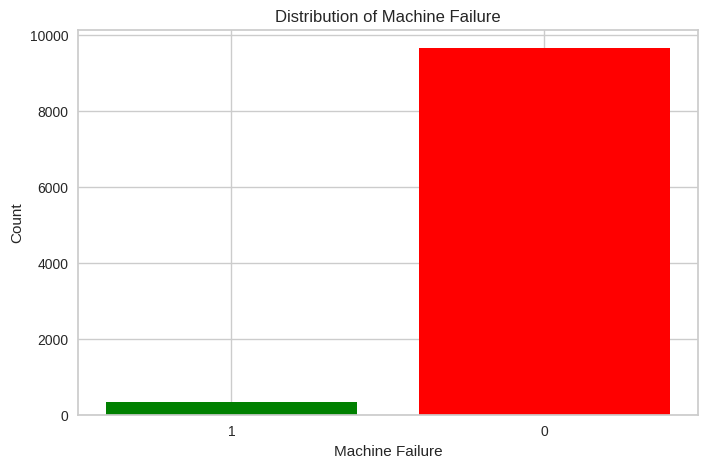

In [ ]:
distribution_data = df.groupBy('Machine failure').count().toPandas()
distribution_data['Machine failure'] = distribution_data['Machine failure'].astype(str)

# Plot the distribution
plt.figure(figsize=(8, 5))
plt.bar(distribution_data['Machine failure'], distribution_data['count'], color=['green', 'red'])
plt.title('Distribution of Machine Failure')
plt.xlabel('Machine Failure')
plt.ylabel('Count')
plt.show()


In [ ]:
distribution_data

Machine failure  count
0               1    339
1               0   9661

In [ ]:
# Create a new column 'Power'
df = df.withColumn('Power', col('Rotational speed') * col('Torque'))

# Show the updated DataFrame
df.show(5)

+----+---------------+-------------------+----------------+------+---------+---------------+---+---+---+---+---+------------------+
|Type|Air temperature|Process temperature|Rotational speed|Torque|Tool wear|Machine failure|TWF|HDF|PWF|OSF|RNF|             Power|
+----+---------------+-------------------+----------------+------+---------+---------------+---+---+---+---+---+------------------+
|   M|          298.1|              308.6|            1551|  42.8|        0|              0|  0|  0|  0|  0|  0| 66382.79999999999|
|   L|          298.2|              308.7|            1408|  46.3|        3|              0|  0|  0|  0|  0|  0|65190.399999999994|
|   L|          298.1|              308.5|            1498|  49.4|        5|              0|  0|  0|  0|  0|  0|           74001.2|
|   L|          298.2|              308.6|            1433|  39.5|        7|              0|  0|  0|  0|  0|  0|           56603.5|
|   L|          298.2|              308.7|            1408|  40.0|        9|

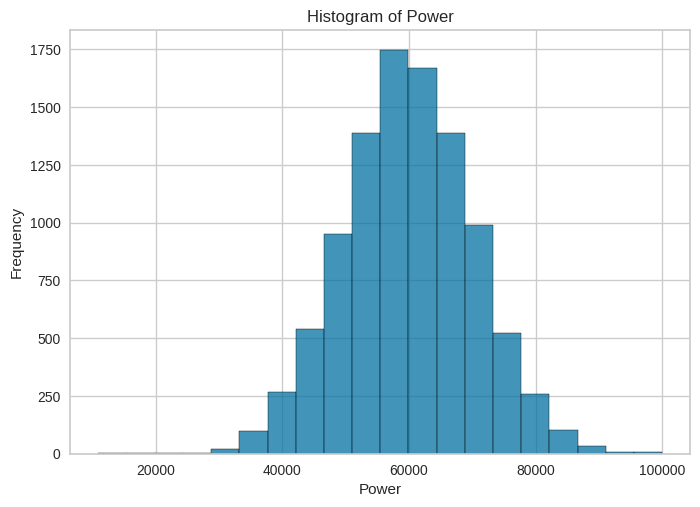

In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame
power_values = df.select('Power').toPandas()

# Plot the histogram using Seaborn
sns.histplot(power_values['Power'], bins=20, kde=False)
plt.title('Histogram of Power')
plt.xlabel('Power')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Combine features into a single vector column
assembler = VectorAssembler(inputCols=df.columns[3:], outputCol="features")
assembled_df = assembler.transform(df)

# Calculate the correlation matrix
corr_matrix = Correlation.corr(assembled_df, "features").collect()[0][0]

# Display the correlation matrix
print("Correlation Matrix:")
print(corr_matrix)

Correlation Matrix:
DenseMatrix([[ 1.00000000e+00, -8.75027086e-01,  2.23084840e-04,
              -4.41875597e-02,  1.03890526e-02, -1.21240693e-01,
               1.23017838e-01, -1.04574712e-01, -1.30875702e-02,
              -8.05583707e-01],
             [-8.75027086e-01,  1.00000000e+00, -3.09278144e-03,
               1.91320775e-01, -1.46616270e-02,  1.42610182e-01,
               8.37810778e-02,  1.83464795e-01,  1.61364992e-02,
               9.78828271e-01],
             [ 2.23084840e-04, -3.09278144e-03,  1.00000000e+00,
               1.05448219e-01,  1.15792057e-01, -1.28734586e-03,
              -9.33444504e-03,  1.55893672e-01,  1.13257088e-02,
              -3.19332058e-03],
             [-4.41875597e-02,  1.91320775e-01,  1.05448219e-01,
               1.00000000e+00,  3.62903611e-01,  5.75800152e-01,
               5.22812250e-01,  5.31083451e-01,  4.51599310e-03,
               1.76039078e-01],
             [ 1.03890526e-02, -1.46616270e-02,  1.15792057e-01,
       

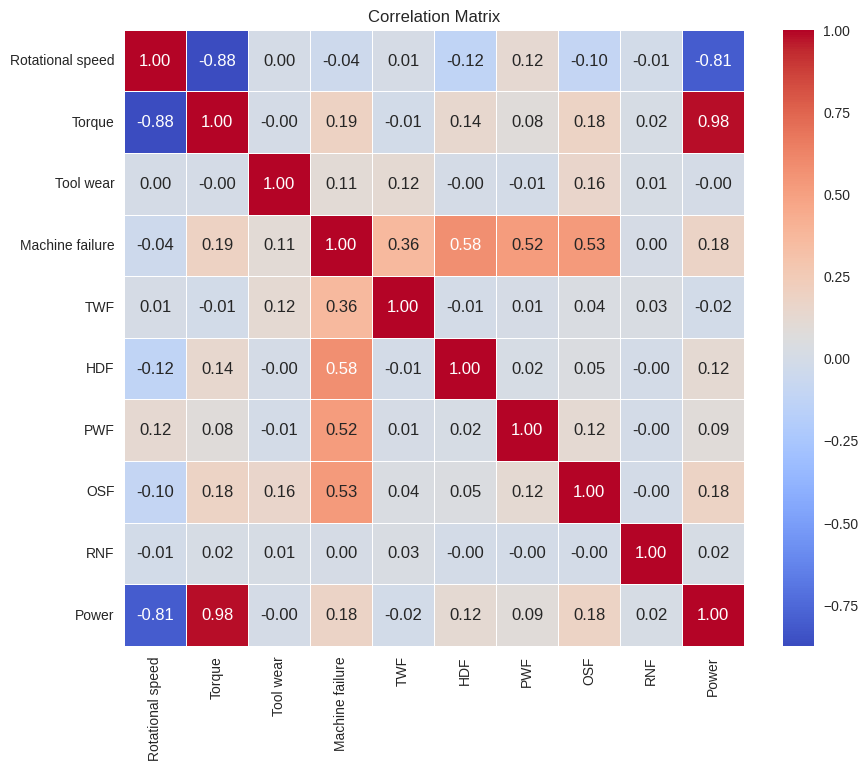

In [ ]:
# Convert the correlation matrix to a Pandas DataFrame
corr_df = pd.DataFrame(corr_matrix.toArray(), columns=df.columns[3:], index=df.columns[3:])

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()


In [ ]:
def histogram(df, col, bins=10, xname=None, yname=None, color='skyblue', edgecolor='black'):
    # Calculating histogram in Spark
    vals = df.select(col).rdd.flatMap(lambda x: x).histogram(bins)

    # Preprocessing histogram points and locations
    width = vals[0][1] - vals[0][0]
    loc = [vals[0][0] + (i+1) * width for i in range(len(vals[1]))]

    # Making a bar plot with modified color and edgecolor
    plt.bar(loc, vals[1], width=width, color=color, edgecolor=edgecolor)
    plt.xlabel(col)
    plt.ylabel(yname)
    plt.title(f'Histogram of {col}')
    plt.show()


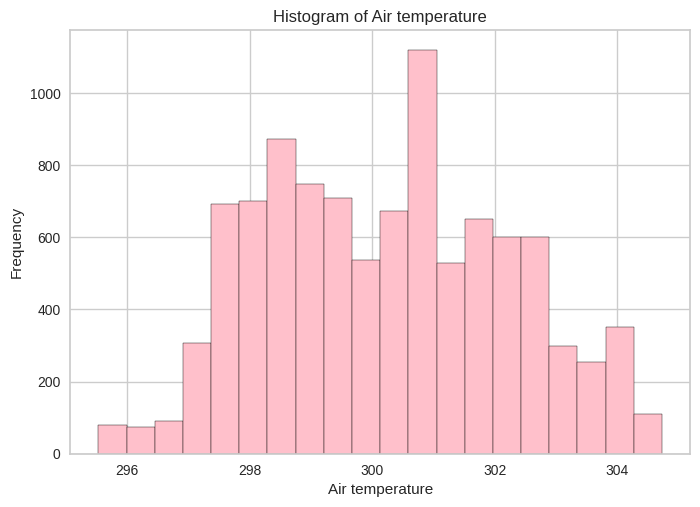

In [ ]:
# Plot histogram for the frequency of 'Air temperature [K]'
histogram(df, 'Air temperature', bins=20, xname='Temperature', yname='Frequency', color='pink', edgecolor='black')

<ipython-input-588-5f0418958503>:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.histplot(pandas_df['NumFailureTypes'], bins=range(pandas_df['NumFailureTypes'].max() + 2),


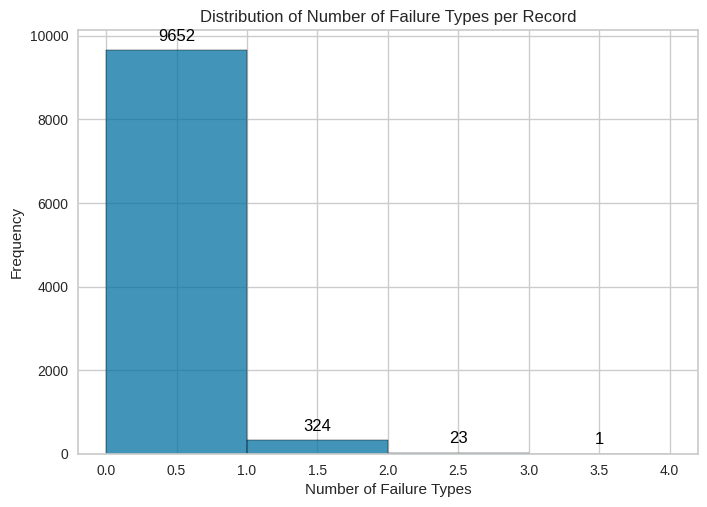

In [ ]:
# Initialize a new column 'NumFailureTypes' with 0
df = df.withColumn('NumFailureTypes', lit(0))

# Update 'NumFailureTypes' based on conditions
failure_columns = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
for failure_col in failure_columns:
    df = df.withColumn('NumFailureTypes', col('NumFailureTypes') + col(failure_col))

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df.select('NumFailureTypes').toPandas()

# Plot the distribution using Seaborn with distinct colors for each bar
ax = sns.histplot(pandas_df['NumFailureTypes'], bins=range(pandas_df['NumFailureTypes'].max() + 2),
                  kde=False, palette='inferno')

plt.title('Distribution of Number of Failure Types per Record')
plt.xlabel('Number of Failure Types')
plt.ylabel('Frequency')

# Annotate the bars with the number of records and set the color
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', color='black')

plt.show()
df = df.drop('NumFailureTypes')


In [ ]:
# Update 'Machine failure' column based on conditions
df = df.withColumn('Machine failure', when((col('TWF') == 1) |
                                           (col('HDF') == 1) |
                                           (col('PWF') == 1) |
                                           (col('OSF') == 1) |
                                           (col('RNF') == 1), 1).otherwise(col('Machine failure')))

# Drop individual failure type columns
columns_to_drop = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
df = df.drop(*columns_to_drop)

# Show the updated DataFrame
df.show(5)

+----+---------------+-------------------+----------------+------+---------+---------------+------------------+
|Type|Air temperature|Process temperature|Rotational speed|Torque|Tool wear|Machine failure|             Power|
+----+---------------+-------------------+----------------+------+---------+---------------+------------------+
|   M|          298.1|              308.6|            1551|  42.8|        0|              0| 66382.79999999999|
|   L|          298.2|              308.7|            1408|  46.3|        3|              0|65190.399999999994|
|   L|          298.1|              308.5|            1498|  49.4|        5|              0|           74001.2|
|   L|          298.2|              308.6|            1433|  39.5|        7|              0|           56603.5|
|   L|          298.2|              308.7|            1408|  40.0|        9|              0|           56320.0|
+----+---------------+-------------------+----------------+------+---------+---------------+------------

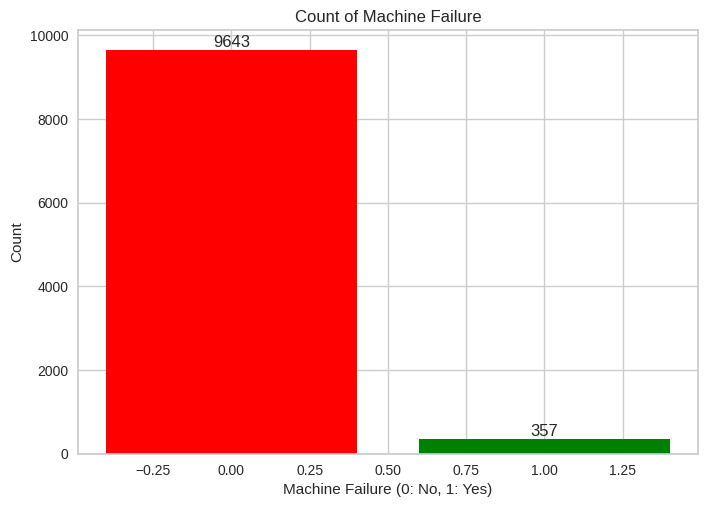

In [ ]:
# Collect data to the driver
pandas_df = df.groupBy('Machine failure').count().toPandas()

# Plot the data using matplotlib
fig, ax = plt.subplots()
ax.bar(pandas_df['Machine failure'], pandas_df['count'], color=['green', 'red'])
ax.set_xlabel('Machine Failure (0: No, 1: Yes)')
ax.set_ylabel('Count')
ax.set_title('Count of Machine Failure')

# Annotate the bars with count values without overlapping
for patch in ax.patches:
    ax.annotate(str(int(patch.get_height())), (patch.get_x() + patch.get_width() / 2, patch.get_height()),
                ha='center', va='bottom')

plt.show()

In [ ]:
# Convert 'Type' attribute into numbers
df = df.withColumn('Type', when(col('Type') == 'L', 0)
                              .when(col('Type') == 'M', 1)
                              .when(col('Type') == 'H', 2)
                              .otherwise(col('Type')))

# Show the updated DataFrame
df.show(5)

+----+---------------+-------------------+----------------+------+---------+---------------+------------------+
|Type|Air temperature|Process temperature|Rotational speed|Torque|Tool wear|Machine failure|             Power|
+----+---------------+-------------------+----------------+------+---------+---------------+------------------+
|   1|          298.1|              308.6|            1551|  42.8|        0|              0| 66382.79999999999|
|   0|          298.2|              308.7|            1408|  46.3|        3|              0|65190.399999999994|
|   0|          298.1|              308.5|            1498|  49.4|        5|              0|           74001.2|
|   0|          298.2|              308.6|            1433|  39.5|        7|              0|           56603.5|
|   0|          298.2|              308.7|            1408|  40.0|        9|              0|           56320.0|
+----+---------------+-------------------+----------------+------+---------+---------------+------------

In [ ]:
# Convert all columns to float
for column in df.columns:
    df = df.withColumn(column, col(column).cast('float'))

# Show the updated DataFrame
df.show(5)

+----+---------------+-------------------+----------------+------+---------+---------------+-------+
|Type|Air temperature|Process temperature|Rotational speed|Torque|Tool wear|Machine failure|  Power|
+----+---------------+-------------------+----------------+------+---------+---------------+-------+
| 1.0|          298.1|              308.6|          1551.0|  42.8|      0.0|            0.0|66382.8|
| 0.0|          298.2|              308.7|          1408.0|  46.3|      3.0|            0.0|65190.4|
| 0.0|          298.1|              308.5|          1498.0|  49.4|      5.0|            0.0|74001.2|
| 0.0|          298.2|              308.6|          1433.0|  39.5|      7.0|            0.0|56603.5|
| 0.0|          298.2|              308.7|          1408.0|  40.0|      9.0|            0.0|56320.0|
+----+---------------+-------------------+----------------+------+---------+---------------+-------+
only showing top 5 rows



In [ ]:
# Print shape before handling outliers
print("Shape before handling outliers: ({}, {})".format(df.count(), len(df.columns)))


Shape before handling outliers: (10000, 8)


In [ ]:
# List of columns to exclude from normalization and winsorization
excluded_columns = ['Type', 'Machine failure']

# Identify and handle outliers using statistical methods
for col in df.columns:
    if col not in excluded_columns:
        # Calculate the IQR (interquartile range)
        quantiles = df.approxQuantile(col, [0.25, 0.75], 0.05)
        Q1 = quantiles[0]
        Q3 = quantiles[1]
        IQR = Q3 - Q1

        # Identify outliers and remove them
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df = df.filter((F.col(col) >= lower_bound) & (F.col(col) <= upper_bound))

# Show the updated DataFrame
df.show(5)

+----+---------------+-------------------+----------------+------+---------+---------------+-------+
|Type|Air temperature|Process temperature|Rotational speed|Torque|Tool wear|Machine failure|  Power|
+----+---------------+-------------------+----------------+------+---------+---------------+-------+
| 1.0|          298.1|              308.6|          1551.0|  42.8|      0.0|            0.0|66382.8|
| 0.0|          298.2|              308.7|          1408.0|  46.3|      3.0|            0.0|65190.4|
| 0.0|          298.1|              308.5|          1498.0|  49.4|      5.0|            0.0|74001.2|
| 0.0|          298.2|              308.6|          1433.0|  39.5|      7.0|            0.0|56603.5|
| 0.0|          298.2|              308.7|          1408.0|  40.0|      9.0|            0.0|56320.0|
+----+---------------+-------------------+----------------+------+---------+---------------+-------+
only showing top 5 rows



In [ ]:
# Print shape after handling outliers
print("Shape after handling outliers: ({}, {})".format(df.count(), len(df.columns)))

Shape after handling outliers: (9282, 8)


In [ ]:
df.show()

+----+---------------+-------------------+----------------+------+---------+---------------+-------+
|Type|Air temperature|Process temperature|Rotational speed|Torque|Tool wear|Machine failure|  Power|
+----+---------------+-------------------+----------------+------+---------+---------------+-------+
| 1.0|          298.1|              308.6|          1551.0|  42.8|      0.0|            0.0|66382.8|
| 0.0|          298.2|              308.7|          1408.0|  46.3|      3.0|            0.0|65190.4|
| 0.0|          298.1|              308.5|          1498.0|  49.4|      5.0|            0.0|74001.2|
| 0.0|          298.2|              308.6|          1433.0|  39.5|      7.0|            0.0|56603.5|
| 0.0|          298.2|              308.7|          1408.0|  40.0|      9.0|            0.0|56320.0|
| 1.0|          298.1|              308.6|          1425.0|  41.9|     11.0|            0.0|59707.5|
| 0.0|          298.1|              308.6|          1558.0|  42.4|     14.0|            0.0

In [ ]:
columns_order = ['Type', 'Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear', 'Power', 'Machine failure']


if all(col_name in df.columns for col_name in columns_order):
    # Sélectionnez les colonnes dans l'ordre souhaité
    df = df.select(columns_order)

df.show()

+----+---------------+-------------------+----------------+------+---------+-------+---------------+
|Type|Air temperature|Process temperature|Rotational speed|Torque|Tool wear|  Power|Machine failure|
+----+---------------+-------------------+----------------+------+---------+-------+---------------+
| 1.0|          298.1|              308.6|          1551.0|  42.8|      0.0|66382.8|            0.0|
| 0.0|          298.2|              308.7|          1408.0|  46.3|      3.0|65190.4|            0.0|
| 0.0|          298.1|              308.5|          1498.0|  49.4|      5.0|74001.2|            0.0|
| 0.0|          298.2|              308.6|          1433.0|  39.5|      7.0|56603.5|            0.0|
| 0.0|          298.2|              308.7|          1408.0|  40.0|      9.0|56320.0|            0.0|
| 1.0|          298.1|              308.6|          1425.0|  41.9|     11.0|59707.5|            0.0|
| 0.0|          298.1|              308.6|          1558.0|  42.4|     14.0|66059.2|       

In [ ]:
df.columns

['Type',
 'Air temperature',
 'Process temperature',
 'Rotational speed',
 'Torque',
 'Tool wear',
 'Power',
 'Machine failure']

# **Modeling**

In [ ]:
# Step 1: Feature Selection
feature_cols = ["Air temperature", "Process temperature", "Rotational speed", "Torque", "Tool wear", "Power","Type"]
features = df.select(*feature_cols)

In [ ]:
# Step 2: Assemble Features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(features)

In [ ]:
# Step 3: Scale Features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
scaled_data = scaler.fit(assembled_data).transform(assembled_data)

In [ ]:
# Step 4: Split Data
train_data, test_data = scaled_data.randomSplit([0.7, 0.3], seed=42)

## **Clustering**

### **k nearest neighbors(KNN)**



#### Optimal parameters

For k = 2, Distortion Score: 0.7369898059657585
For k = 3, Distortion Score: 0.7049001245000596
For k = 4, Distortion Score: 0.6957493192413048
For k = 5, Distortion Score: 0.6844140802423598
For k = 6, Distortion Score: 0.6916782373571938
For k = 7, Distortion Score: 0.681753520485054
For k = 8, Distortion Score: 0.678393118613295
For k = 9, Distortion Score: 0.676047811935306
For k = 10, Distortion Score: 0.6796937529900395


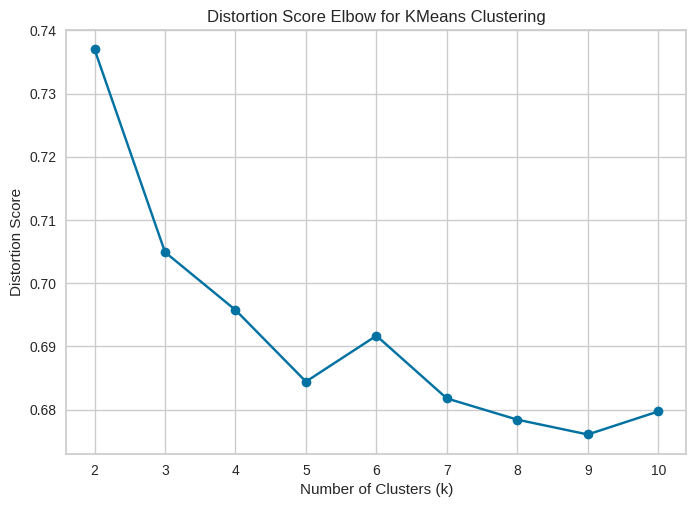

In [ ]:
# Calculate distortion for different values of k
distortions = []
for k in range(2, 11):
    kmeans = KMeans(k=k, seed=1)
    model = kmeans.fit(scaled_data)

    # Make predictions
    predictions = model.transform(scaled_data)

    # Evaluate clustering using distortion (sum of squared distances to the nearest cluster center)
    evaluator = ClusteringEvaluator()
    distortion = evaluator.evaluate(predictions, {evaluator.metricName: "silhouette"})
    distortions.append(distortion)

    print(f"For k = {k}, Distortion Score: {distortion}")

# Plot the distortion scores
plt.plot(range(2, 11), distortions, marker='o')
plt.title('Distortion Score Elbow for KMeans Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion Score')
plt.show()

In [ ]:
# optimal number of clusters
optimal_k = 2

# Fit KMeans model with the optimal number of clusters
kmeans = KMeans(k=optimal_k, seed=1)
model = kmeans.fit(scaled_data)

In [ ]:
# Make predictions
predictions = model.transform(scaled_data)

# Evaluate clustering using silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score for {optimal_k} clusters: {silhouette}")


Silhouette Score for 2 clusters: 0.7369898059657585


* Silhouette score of 0.7369 indicates good cluster separation.

In [ ]:
# Display cluster centers
print("Cluster Centers:")
centers = model.clusterCenters()
for i, center in enumerate(centers):
    print(f"Cluster {i + 1}: {center}")

Cluster Centers:
Cluster 1: [2.99998297e+02 3.09997538e+02 1.42809733e+03 4.80847676e+01
 1.07523010e+02 6.83817033e+04 5.04832029e-01]
Cluster 2: [2.99984805e+02 3.10004315e+02 1.58416896e+03 3.44450972e+01
 1.08557536e+02 5.40884782e+04 4.98379254e-01]


* Clusters centers show distinct feature patterns for each cluster.

<Figure size 1000x800 with 0 Axes>

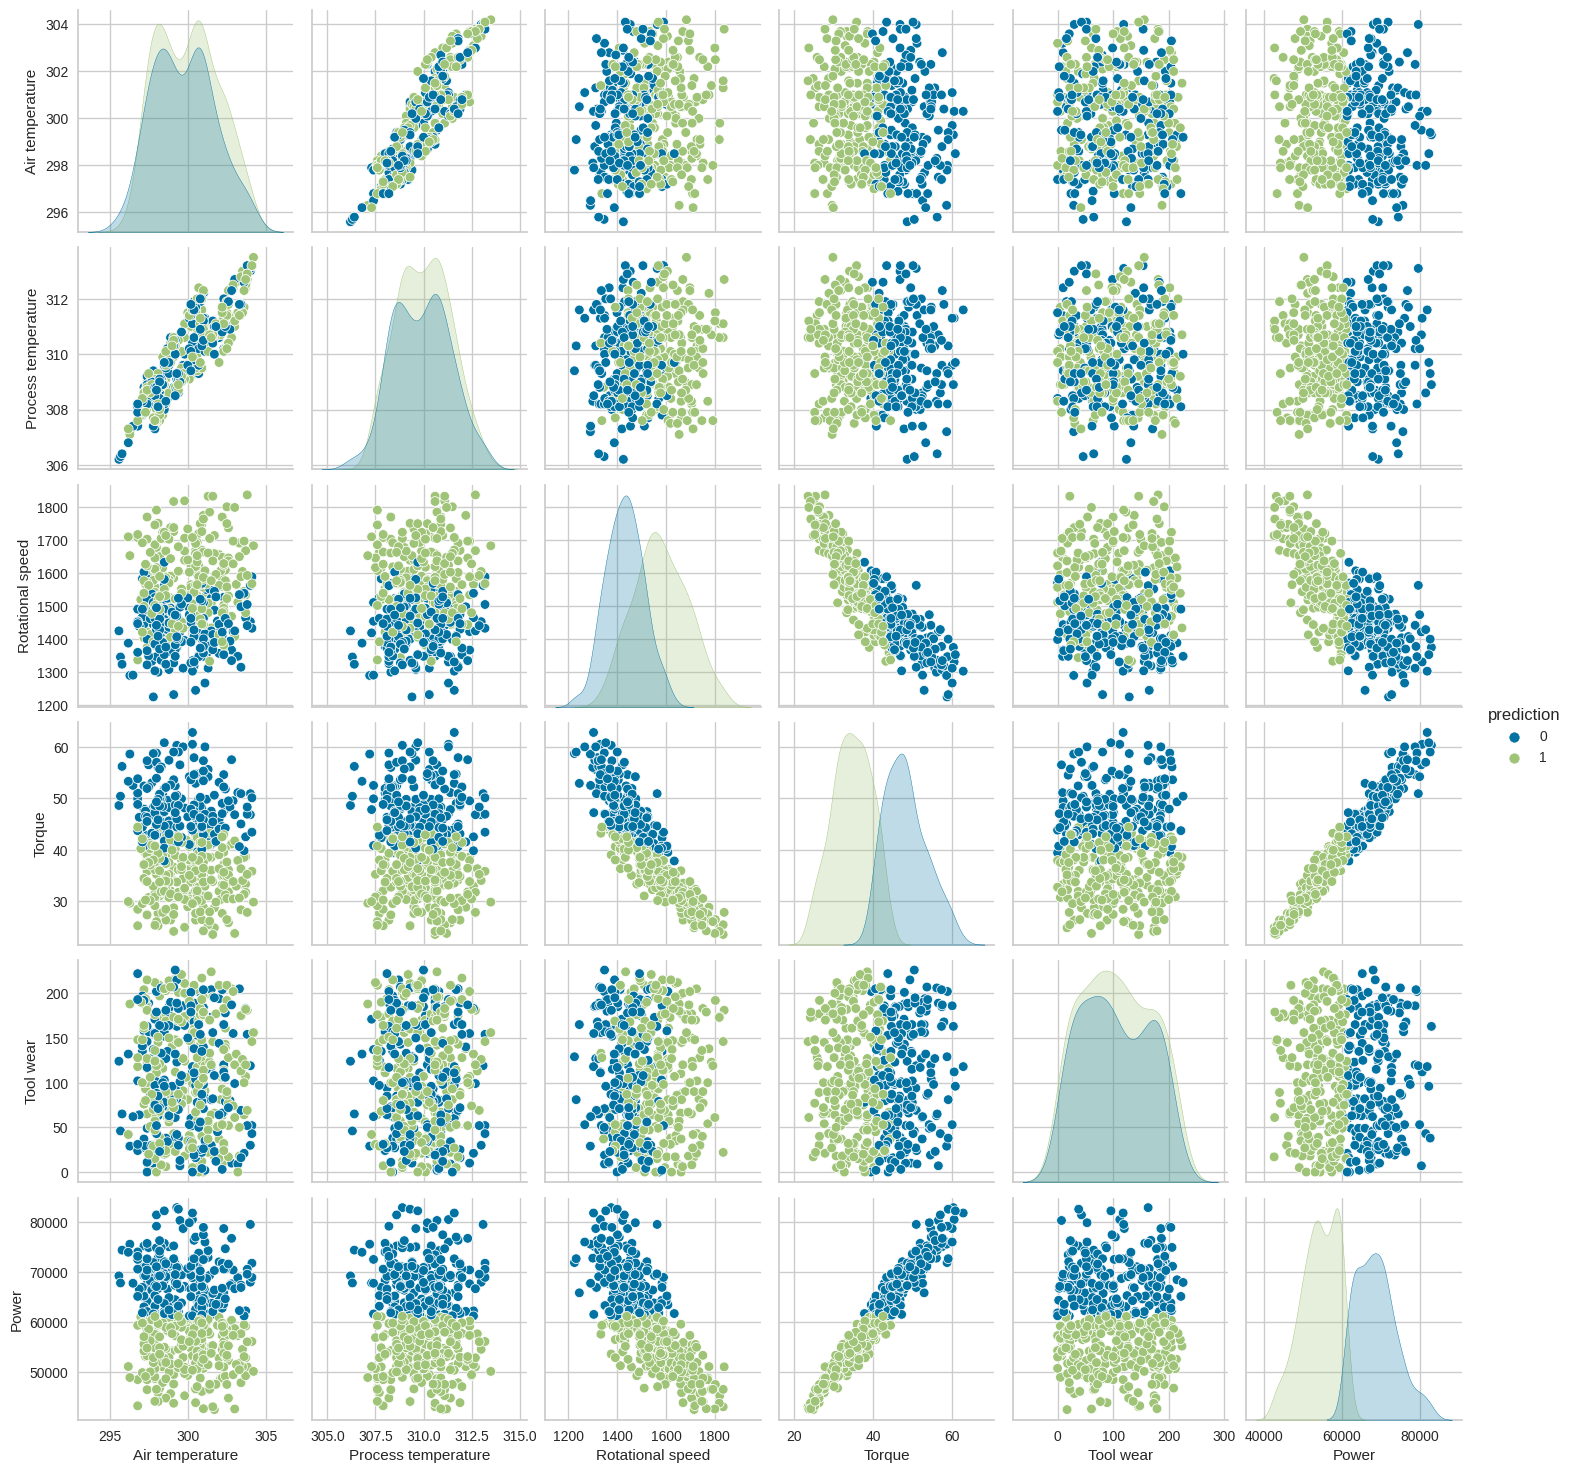

In [ ]:
# Convert Spark DataFrame to Pandas for Seaborn plotting
pandas_data = predictions.select(*feature_cols[:-1], "prediction").toPandas()

# Plot pairplot
plt.figure(figsize=(10, 8))
sns.pairplot(pandas_data.sample(frac=0.05), hue="prediction", vars=feature_cols[:-1])
plt.show()


### **Gaussian Mixture Model (GMM)**

Un modèle probabiliste qui suppose que les données sont générées à partir d'un mélange de plusieurs distributions gaussiennes.

#### Optimal parameters

In [ ]:
# Calculate silhouette scores for different values of k
silhouette_scores = []
for k in range(2, 11):
    gmm = GaussianMixture(k=k, seed=1)
    model = gmm.fit(scaled_data)

    # Make predictions
    predictions = model.transform(scaled_data)

    # Evaluate clustering using silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions, {evaluator.metricName: "silhouette"})
    silhouette_scores.append(silhouette)

    print(f"For k = {k}, Silhouette Score: {silhouette}")


For k = 2, Silhouette Score: 0.5737471815503108
For k = 3, Silhouette Score: 0.13699330904675933
For k = 4, Silhouette Score: 0.06960596370371423
For k = 5, Silhouette Score: -0.022290113630658973
For k = 6, Silhouette Score: -0.10961648778466658
For k = 7, Silhouette Score: -0.18161248884793327
For k = 8, Silhouette Score: -0.1470319648164424
For k = 9, Silhouette Score: -0.18882214884826853
For k = 10, Silhouette Score: -0.24422439323463288


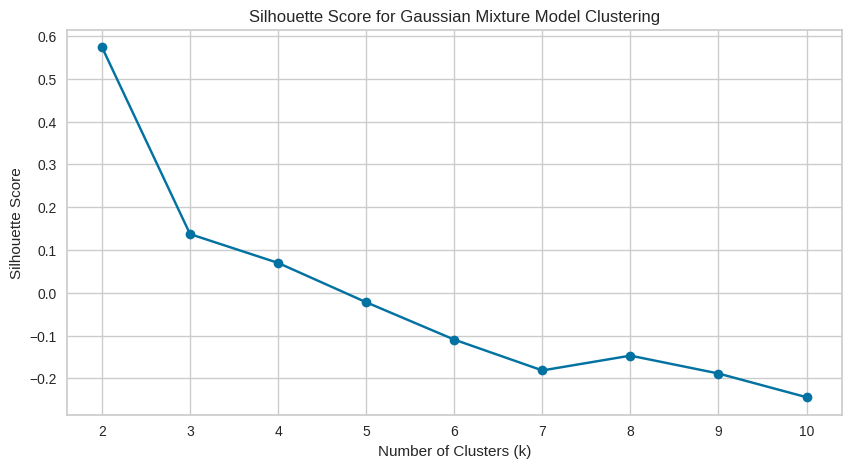

In [ ]:
# Plot the silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Gaussian Mixture Model Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
# Find the optimal number of clusters
optimal_k = np.argmax(silhouette_scores) + 2
print(f"Optimal Number of Clusters (k): {optimal_k}")

Optimal Number of Clusters (k): 2


In [ ]:
# Fit GMM model with the optimal number of clusters
gmm = GaussianMixture(k=optimal_k, seed=1)
model = gmm.fit(scaled_data)

# Make predictions and add the 'prediction' column to the DataFrame
predictions = model.transform(scaled_data)

In [ ]:
# Evaluate clustering using silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score for {optimal_k} clusters: {silhouette}")

Silhouette Score for 2 clusters: 0.5737471815503108


<Figure size 1000x800 with 0 Axes>

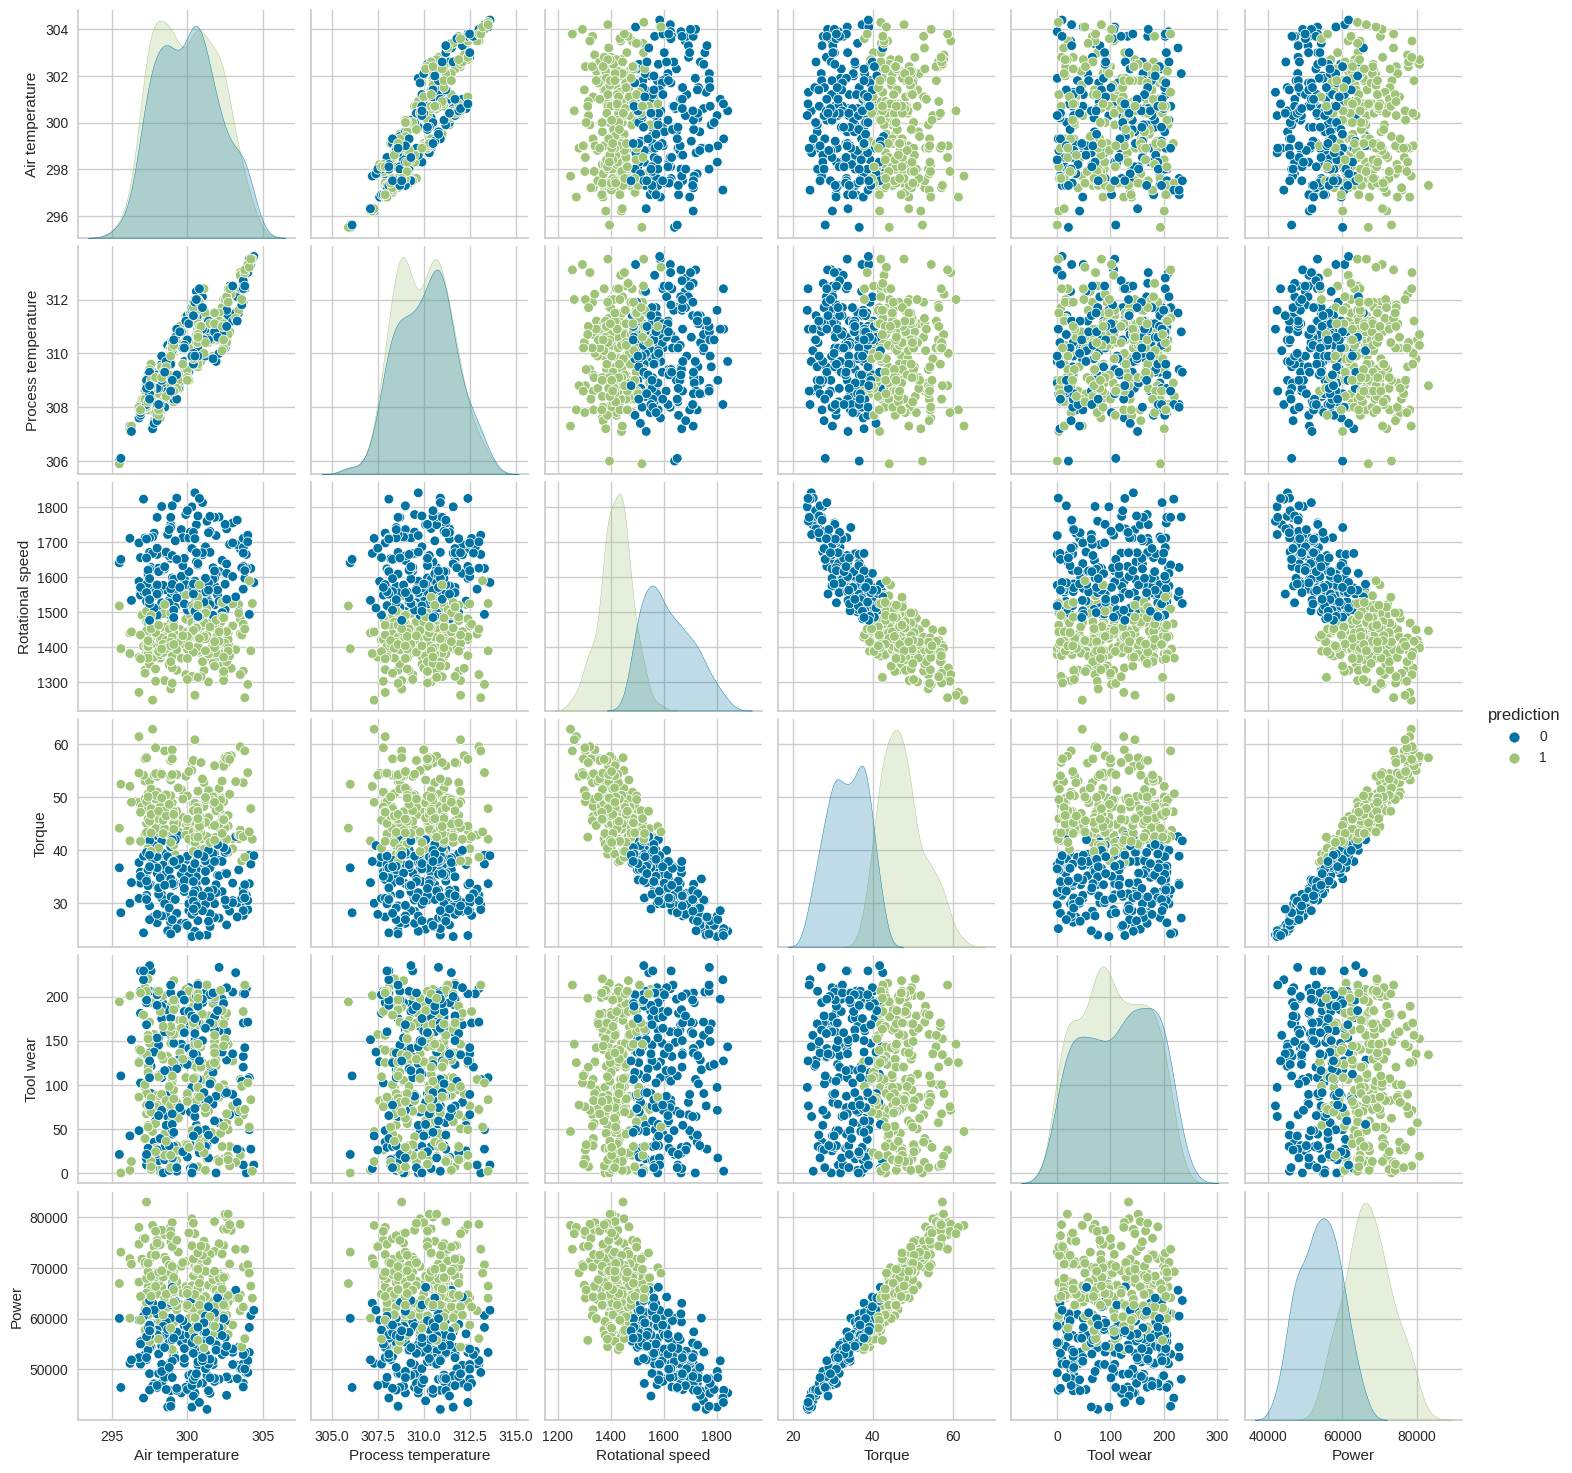

In [ ]:
# Convert Spark DataFrame to Pandas for Seaborn plotting
pandas_data = predictions.select(*feature_cols[:-1], "prediction").toPandas()

# Plot pairplot
plt.figure(figsize=(10, 8))
sns.pairplot(pandas_data.sample(frac=0.05), hue="prediction", vars=feature_cols[:-1])
plt.show()

### **Bisecting K-means**



####Optimal parameters

In [ ]:
# Calculate distortion for different values of k
distortions = []
for k in range(2, 11):
    bisecting_kmeans = BisectingKMeans(k=k, seed=1)
    model = bisecting_kmeans.fit(scaled_data)

    # Make predictions
    predictions = model.transform(scaled_data)

    # Evaluate clustering using distortion (sum of squared distances to the nearest cluster center)
    evaluator = ClusteringEvaluator()
    distortion = evaluator.evaluate(predictions, {evaluator.metricName: "silhouette"})
    distortions.append(distortion)

    print(f"For k = {k}, Distortion Score: {distortion}")

For k = 2, Distortion Score: 0.7369898059657585
For k = 3, Distortion Score: 0.6026128029458862
For k = 4, Distortion Score: 0.6951783291930622
For k = 5, Distortion Score: 0.5794301884848431
For k = 6, Distortion Score: 0.5876377197744417
For k = 7, Distortion Score: 0.6340619064046927
For k = 8, Distortion Score: 0.6807340427898103
For k = 9, Distortion Score: 0.6371486434155273
For k = 10, Distortion Score: 0.6279868215663875


In [ ]:
# Find the optimal number of clusters
optimal_k = np.argmax(distortions) + 2
print(f"Optimal Number of Clusters (k): {optimal_k}")

Optimal Number of Clusters (k): 2


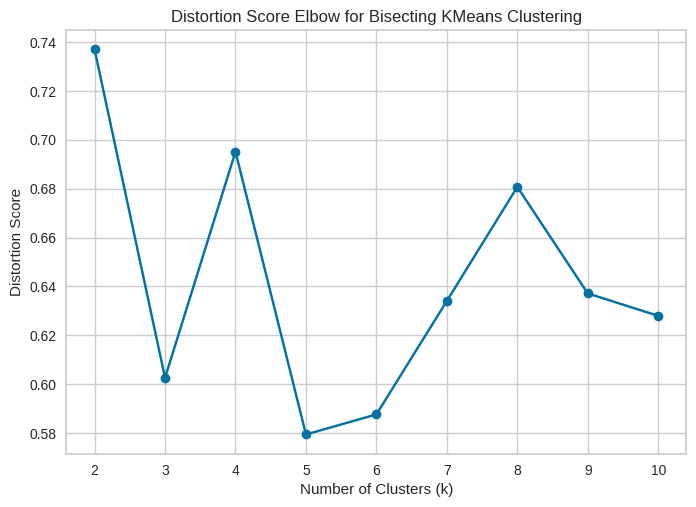

In [ ]:
# Plot the distortion scores
plt.plot(range(2, 11), distortions, marker='o')
plt.title('Distortion Score Elbow for Bisecting KMeans Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion Score')
plt.show()

In [ ]:
# Set the optimal number of clusters
optimal_k = 2

# Fit Bisecting KMeans model with the optimal number of clusters
bisecting_kmeans = BisectingKMeans(k=optimal_k, seed=1)
model = bisecting_kmeans.fit(scaled_data)

<Figure size 1000x800 with 0 Axes>

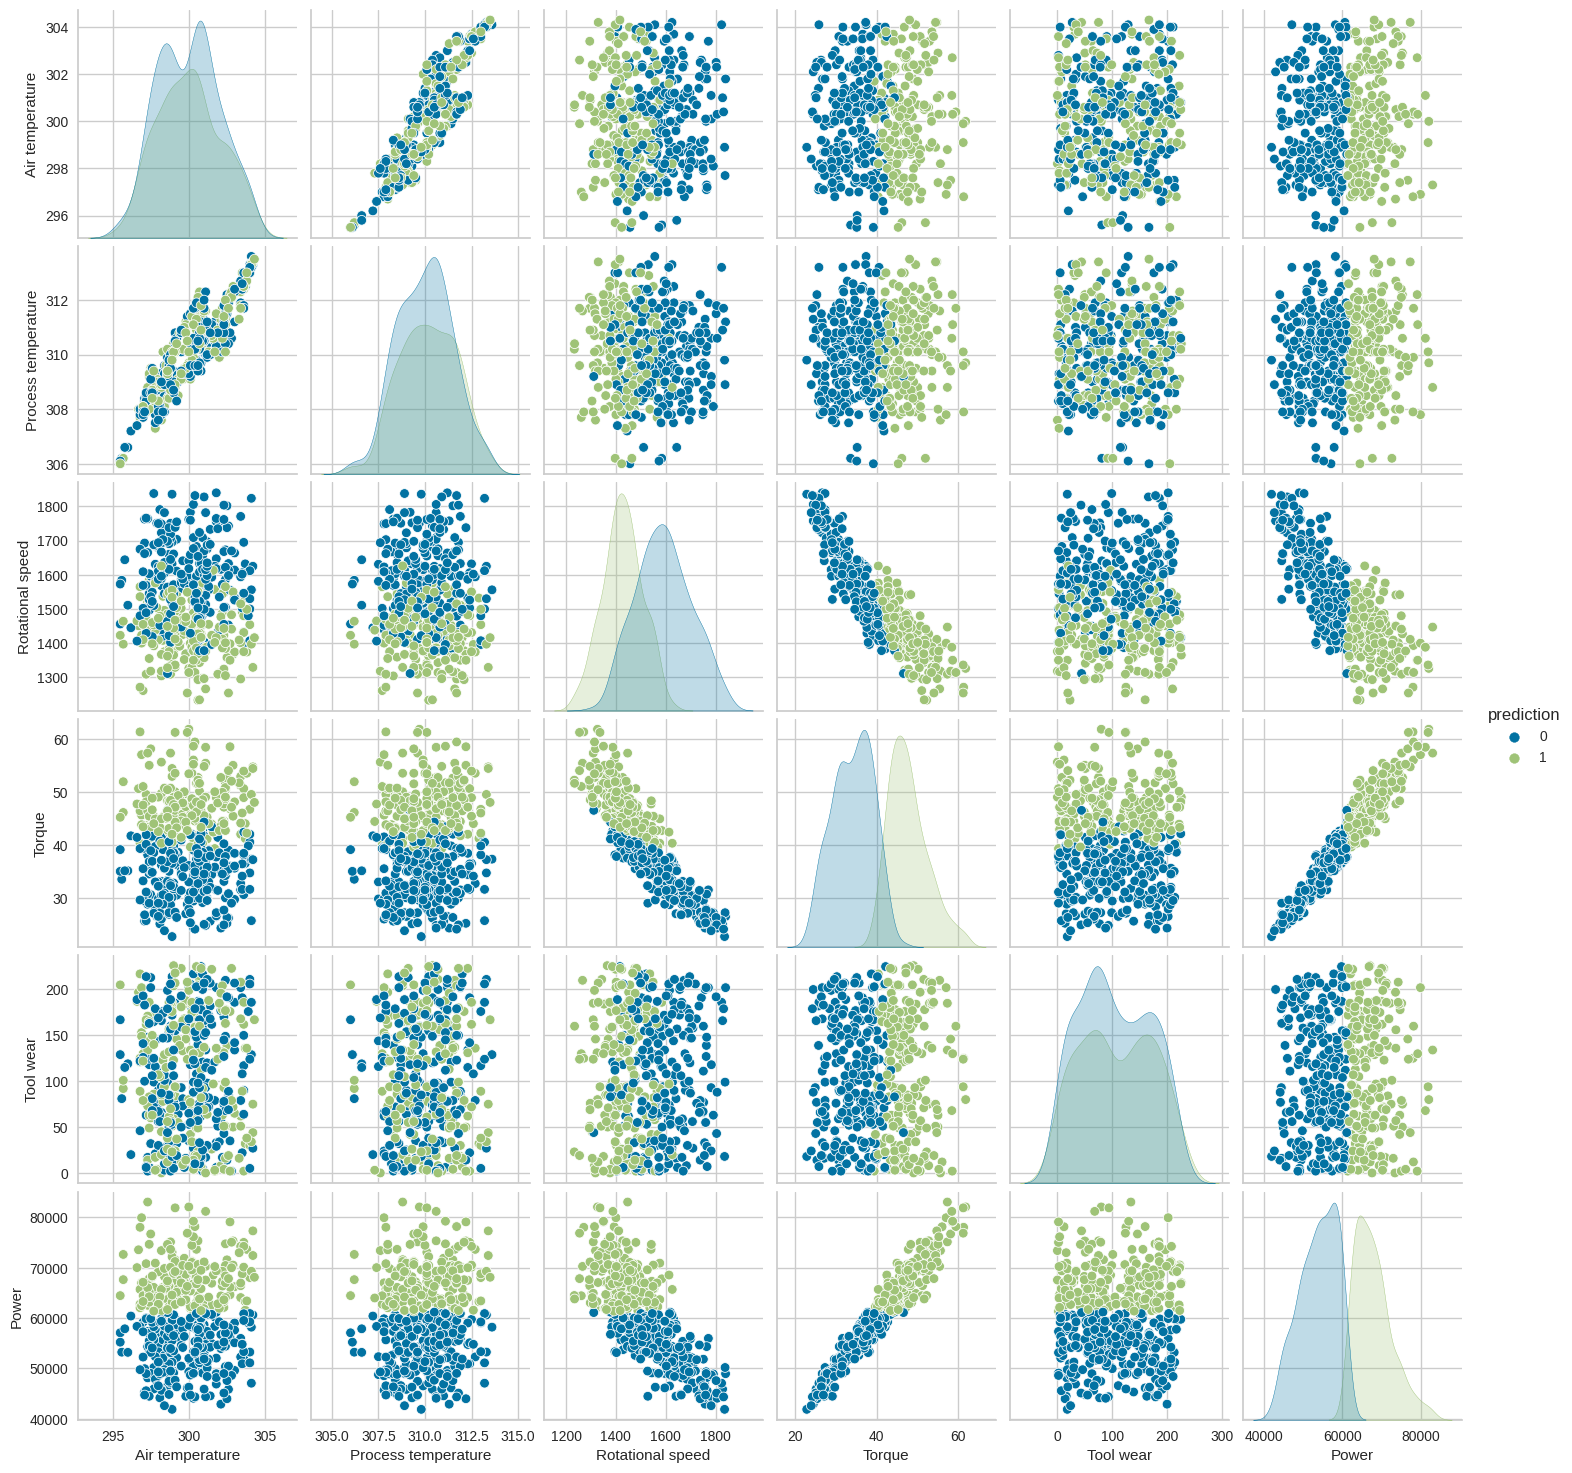

In [ ]:
# Make predictions and add the 'prediction' column to the DataFrame
predictions = model.transform(scaled_data)

# Convert Spark DataFrame to Pandas for Seaborn plotting
pandas_data = predictions.select(*feature_cols[:-1], "prediction").toPandas()

# Plot pairplot
plt.figure(figsize=(10, 8))
sns.pairplot(pandas_data.sample(frac=0.05), hue="prediction", vars=feature_cols[:-1])
plt.show()

## Classification Models

## Diviser l'ensemble de données (80 % d'entraînement : 20 % de test).

In [ ]:
#  Feature Selection
feature_cols = ["Air temperature", "Process temperature", "Rotational speed", "Torque", "Tool wear", "Power"]
label_col = "Machine failure"

features = df.select(*feature_cols, label_col)

In [ ]:
#Assemble Features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(features)

In [ ]:
#Split Data
train_data, test_data = assembled_data.randomSplit([0.8, 0.2], seed=42)


### **Decision Tree**

In [ ]:
#Build Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(featuresCol="features", labelCol=label_col)

In [ ]:
# Create Pipeline
pipeline = Pipeline(stages=[dt_classifier])

# Measure Training Time
start_time = time.time()
#  Train the Model
model = pipeline.fit(train_data)
end_time = time.time()
training_time = end_time - start_time

print(f"Training Time: {training_time} seconds")

# Make Predictions
start_time = time.time()
#  Make Predictions
predictions = model.transform(test_data)
end_time = time.time()
prediction_time = end_time - start_time

print(f"Prediction Time: {prediction_time} seconds")

Training Time: 1.4922311305999756 seconds
Prediction Time: 0.028829336166381836 seconds


In [ ]:
#  Evaluate the Model
evaluator = BinaryClassificationEvaluator(labelCol=label_col)
area_under_curve = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print(f"Area Under ROC Curve: {area_under_curve}")

Area Under ROC Curve: 0.6527439991540656


In [ ]:
# Evaluate the Model
evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.9860022396416573
Precision: 0.9848630182103982
Recall: 0.9860022396416573
F1 Score: 0.9847674715465636


In [ ]:
#  View the results
predictions.select("features", "prediction", label_col).show()

+--------------------+----------+---------------+
|            features|prediction|Machine failure|
+--------------------+----------+---------------+
|[295.5,305.899993...|       0.0|            0.0|
|[295.5,306.0,1326...|       0.0|            0.0|
|[295.5,306.0,1456...|       0.0|            0.0|
|[295.5,306.0,1800...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.700012207031...|       0.0|            0.0|
|[295.700012207031...|       0.0|            0.0|
|[295.700012207031...|       0.0|            0.0|
|[295.799987792968...|       0.0|            0.0|


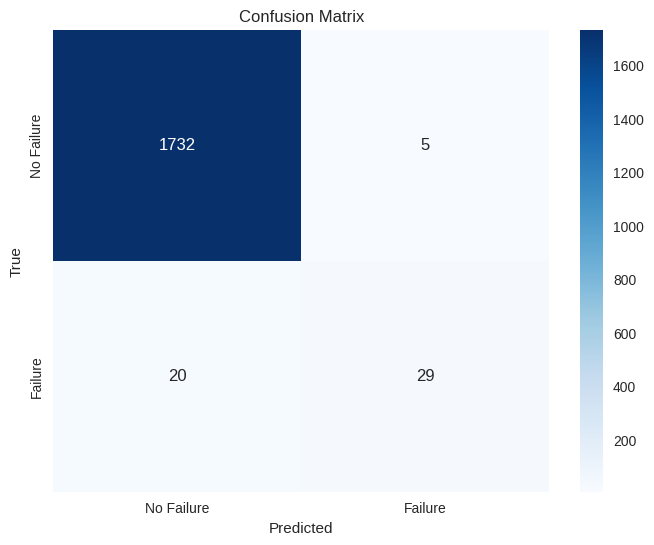

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame for confusion matrix calculation
y_true = predictions.select(label_col).toPandas()['Machine failure']
y_pred = predictions.select('prediction').toPandas()['prediction']

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualize Confusion Matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Les résultats pour le modèle Decision Tree Classifier sont les suivants :

* **Précision (Precision)** 0.985 :
La précision mesure la proportion d'instances correctement prédites parmi toutes les instances prédites comme positives. Un score de précision de 0.985 indique que le modèle est très précis dans ses prédictions.

* **Rappel (Recall)**  0.986 :
Le rappel mesure la proportion d'instances positives correctement prédites parmi toutes les instances réellement positives. Un score de rappel de 0.986 indique que le modèle a une capacité élevée à trouver toutes les instances positives.

* **Score F1 (F1 Score)** 0.985 :
Le score F1 est la moyenne harmonique entre la précision et le rappel. Il fournit une mesure globale de la performance du modèle. Un score F1 de 0.985 suggère une excellente balance entre la précision et le rappel.
* **Exactitude (Accuracy)** 0.986 :
L'exactitude mesure la proportion d'instances correctement prédites parmi toutes les instances. Un score d'exactitude de 0.986 indique une performance globale élevée du modèle.

 * **Temps de traitement** :Le temps d'entraînement est raisonnablement court, indiquant une bonne efficacité dans la construction du modèle de l'arbre de décision.
Le temps de prédiction est également assez rapide, ce qui suggère que le modèle peut faire des prédictions rapidement une fois qu'il est entraîné.

### **RandomForest**

In [ ]:
# Build Random Forest Classifier
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol=label_col, numTrees=10)

# Create Pipeline
pipeline = Pipeline(stages=[rf_classifier])

# Measure Training Time
start_time = time.time()
#  Train the Model
model = pipeline.fit(train_data)
end_time = time.time()
training_time = end_time - start_time

print(f"Training Time: {training_time} seconds")

# Make Predictions
start_time = time.time()
#  Make Predictions
predictions = model.transform(test_data)
end_time = time.time()
prediction_time = end_time - start_time

print(f"Prediction Time: {prediction_time} seconds")

Training Time: 1.766190767288208 seconds
Prediction Time: 0.044214487075805664 seconds


In [ ]:
# Evaluate the Model
evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"Accuracy: {accuracy}")


Precision: 0.976880865540281
Recall: 0.9781634938409854
F1 Score: 0.9716560068067973
Accuracy: 0.9781634938409854


In [ ]:
# View the results
predictions.select("features", "prediction", label_col).show()

+--------------------+----------+---------------+
|            features|prediction|Machine failure|
+--------------------+----------+---------------+
|[295.5,305.899993...|       0.0|            0.0|
|[295.5,306.0,1326...|       0.0|            0.0|
|[295.5,306.0,1456...|       0.0|            0.0|
|[295.5,306.0,1800...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.700012207031...|       0.0|            0.0|
|[295.700012207031...|       0.0|            0.0|
|[295.700012207031...|       0.0|            0.0|
|[295.799987792968...|       0.0|            0.0|


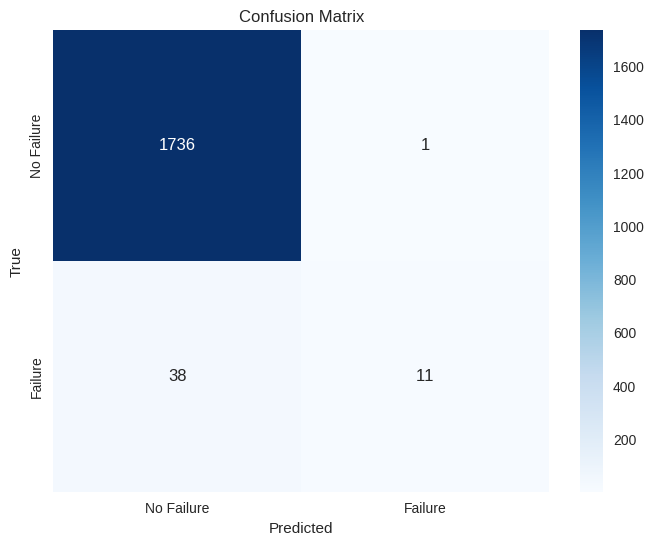

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame for confusion matrix calculation
y_true = predictions.select(label_col).toPandas()['Machine failure']
y_pred = predictions.select('prediction').toPandas()['prediction']

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualize Confusion Matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Grid Search

In [ ]:
# Define Parameter Grid
param_grid = ParamGridBuilder() \
    .addGrid(rf_classifier.numTrees, [10, 20, 30]) \
    .addGrid(rf_classifier.maxDepth, [5, 10, 15]) \
    .build()

# : Create CrossValidator
evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
cross_validator = CrossValidator(estimator=pipeline,
                                 estimatorParamMaps=param_grid,
                                 evaluator=evaluator,
                                 numFolds=3)

# Train the Model
cv_model = cross_validator.fit(train_data)

# Print Best Parameters
best_num_trees = cv_model.bestModel.stages[-1].getNumTrees
best_max_depth = cv_model.bestModel.stages[-1].getMaxDepth

print(f"Best Number of Trees: {best_num_trees}")
print(f"Best Max Depth: {best_max_depth}")

Best Number of Trees: 20
Best Max Depth: <bound method _DecisionTreeParams.getMaxDepth of RandomForestClassificationModel: uid=RandomForestClassifier_5cc06c2a75b4, numTrees=20, numClasses=2, numFeatures=6>


In [ ]:
#  Make Predictions
predictions = cv_model.transform(test_data)

#  Evaluate the Model
accuracy = evaluator.evaluate(predictions)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print(f"Best Model Accuracy: {accuracy}")
print(f"Best Model Precision: {precision}")
print(f"Best Model Recall: {recall}")
print(f"Best Model F1 Score: {f1_score}")

Best Model Accuracy: 0.9854423292273237
Best Model Precision: 0.984430483978725
Best Model Recall: 0.9854423292273236
Best Model F1 Score: 0.9836176259499301


Les résultats après l'application de la recherche de grille (grid search) sur le modèle Random Forest Classifier sont les suivants :

* **Précision (Precision)**  0.9854 :
La précision après la recherche de grille a augmenté, indiquant que le modèle a une meilleure capacité à prédire correctement les instances positives parmi celles prédites positives.

* **Rappel (Recall)**  0.9854 :
Le rappel a également augmenté, suggérant que le modèle est meilleur pour retrouver toutes les instances positives réelles.

* **Score F1 (F1 Score)** 0.9836 :
Le score F1, qui combine précision et rappel, a également augmenté, ce qui indique une amélioration globale de la performance du modèle.
* **Exactitude (Accuracy)** 0.9854:
L'exactitude a également augmenté, montrant une amélioration générale de la capacité du modèle à prédire correctement toutes les instances.

*  la recherche de grille a conduit à une amélioration significative des performances du modèle Random Forest Classifier sur l'ensemble de données, avec des scores plus élevés pour toutes les métriques évaluées.

 * **Temps de traitement** : La forêt aléatoire, en tant qu'ensemble d'arbres de décision, a un temps d'entraînement légèrement plus long, mais elle offre généralement une meilleure performance prédictive.
Le temps de prédiction est comparable à celui de l'arbre de décision, ce qui suggère une efficacité dans la génération de prédictions.

### **Gradient-Boosted Tree Classifier**

In [ ]:
# Build Gradient Boosting Classifier
gbt_classifier = GBTClassifier(featuresCol="features", labelCol=label_col, maxIter=10)

# Create Pipeline
pipeline = Pipeline(stages=[gbt_classifier])

# Measure Training Time
start_time = time.time()
model = pipeline.fit(train_data)
end_time = time.time()
training_time = end_time - start_time

print(f"Training Time: {training_time} seconds")

# Make Predictions
start_time = time.time()
predictions = model.transform(test_data)
end_time = time.time()
prediction_time = end_time - start_time

print(f"Prediction Time: {prediction_time} seconds")

Training Time: 3.713066816329956 seconds
Prediction Time: 0.04683208465576172 seconds


In [ ]:
# Evaluate the Model
evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"Accuracy: {accuracy}")

Precision: 0.9842682308961253
Recall: 0.9854423292273237
F1 Score: 0.9838421110354302
Accuracy: 0.9854423292273237


In [ ]:
# View the results
predictions.select("features", "prediction", label_col).show()

+--------------------+----------+---------------+
|            features|prediction|Machine failure|
+--------------------+----------+---------------+
|[295.5,305.899993...|       0.0|            0.0|
|[295.5,306.0,1326...|       0.0|            0.0|
|[295.5,306.0,1456...|       0.0|            0.0|
|[295.5,306.0,1800...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.700012207031...|       0.0|            0.0|
|[295.700012207031...|       0.0|            0.0|
|[295.700012207031...|       0.0|            0.0|
|[295.799987792968...|       0.0|            0.0|


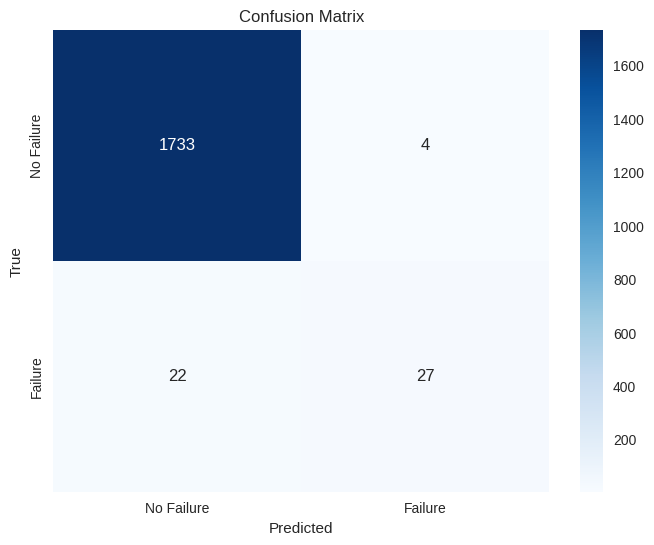

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame for confusion matrix calculation
y_true = predictions.select(label_col).toPandas()[label_col]
y_pred = predictions.select('prediction').toPandas()['prediction']

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualize Confusion Matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Les résultats pour le modèle Gradient Boosted Tree sont les suivants :

* **Précision (Precision)** 0.984:
 Un score de précision de 0.984 indique que le modèle est très précis dans ses prédictions.

* **Rappel (Recall)** 0.985:
Un score de rappel de 0.985 indique que le modèle a une capacité élevée à trouver toutes les instances positives.

* **Score F1 (F1 Score)**  0.983:
 Un score F1 de 0.983 suggère une excellente balance entre la précision et le rappel.
* **Exactitude (Accuracy)** 0.985 :
 Un score d'exactitude de 0.985 indique une performance globale élevée du modèle.

 * **Temps de traitement** : Ce modèle  a pris environ  6.78secondes pour être entraîné, ce qui est généralement lent mais acceptable .Avec un temps de prédiction de 0.0877 seconde, le modèle est capable de générer des prédictions rapidement.Ces résultats indiquent que le modèle de Gradient Boosting Classifier a été efficacement entraîné et peut générer des prédictions de manière rapide.

### **LogisticRegression**

In [ ]:
# Build Logistic Regression Classifier
lr_classifier = LogisticRegression(featuresCol="features", labelCol=label_col)

# Create Pipeline
pipeline = Pipeline(stages=[lr_classifier])

# Measure Training Time
start_time = time.time()
model = pipeline.fit(train_data)
end_time = time.time()
training_time = end_time - start_time

print(f"Training Time: {training_time} seconds")

# Make Predictions
start_time = time.time()
predictions = model.transform(test_data)
end_time = time.time()
prediction_time = end_time - start_time

print(f"Prediction Time: {prediction_time} seconds")

Training Time: 1.9110727310180664 seconds
Prediction Time: 0.0312960147857666 seconds


In [ ]:
# Evaluate the Model
evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"Accuracy: {accuracy}")

Precision: 0.9770389520138836
Recall: 0.9764837625979843
F1 Score: 0.9678056289150732
Accuracy: 0.9764837625979843


In [ ]:
# View the results
predictions.select("features", "prediction", label_col).show()

+--------------------+----------+---------------+
|            features|prediction|Machine failure|
+--------------------+----------+---------------+
|[295.5,305.899993...|       0.0|            0.0|
|[295.5,306.0,1326...|       0.0|            0.0|
|[295.5,306.0,1456...|       0.0|            0.0|
|[295.5,306.0,1800...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.700012207031...|       0.0|            0.0|
|[295.700012207031...|       0.0|            0.0|
|[295.700012207031...|       0.0|            0.0|
|[295.799987792968...|       0.0|            0.0|


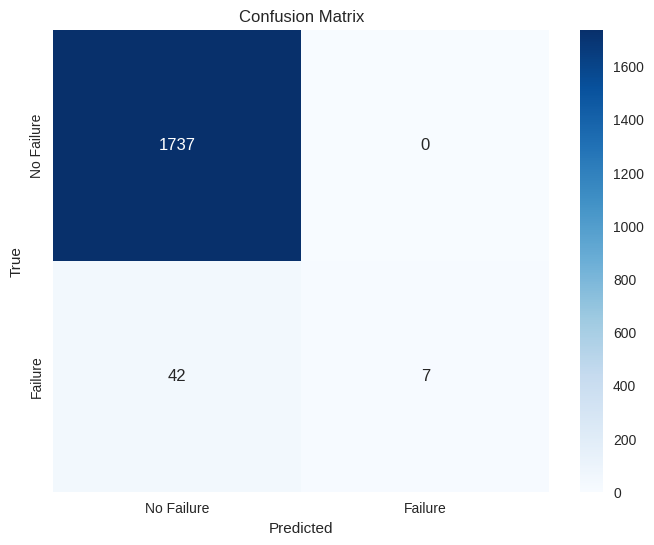

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame for confusion matrix calculation
y_true = predictions.select(label_col).toPandas()[label_col]
y_pred = predictions.select('prediction').toPandas()['prediction']

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualize Confusion Matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Les résultats pour le modèle de Régression Logistique sont les suivants :

* **Précision (0.9770)** :environ 97,7 % des instances prédites comme positives par le modèle sont effectivement des vrais positifs. Cela implique un niveau élevé de confiance dans la justesse des prédictions positives.

* **Rappel (0.9765)** :le modèle de régression logistique capture environ 97,7 % de l'ensemble des instances positives, démontrant son efficacité pour identifier la majorité des cas positifs.

* **Score F1 (0.9678)** :le modèle de régression logistique atteint un équilibre solide entre la précision et le rappel, signifiant une performance robuste tant pour identifier correctement les instances positives que pour minimiser les faux positifs.

* **Exactitude (0.9765)** : le modèle est correct dans ses prédictions pour environ 97,7 % des instances, soulignant sa compétence à faire des prédictions précises globales, aussi bien pour les classes positives que négatives.

 * **Temps de traitement** :Le temps d'entraînement du modèle a été mesuré à 2.64 secondes, ce qui représente la durée totale nécessaire pour ajuster le modèle aux données d'entraînement. Ensuite, le temps de prédiction a été mesuré à 0.034 secondes, indiquant le temps nécessaire pour effectuer des prédictions sur les données de test après l'entraînement du modèle. Ces temps de traitement relativement courts suggèrent une **efficacité temporelle** du modèle,

### **Support Vector Machine (SVM)**

In [ ]:
# Build Linear SVM Classifier
svm_classifier = LinearSVC(featuresCol="features", labelCol=label_col)

# Create Pipeline
pipeline = Pipeline(stages=[svm_classifier])

# Measure Training Time
start_time = time.time()
model = pipeline.fit(train_data)
end_time = time.time()
training_time = end_time - start_time

print(f"Training Time: {training_time} seconds")

# Make Predictions
start_time = time.time()
predictions = model.transform(test_data)
end_time = time.time()
prediction_time = end_time - start_time

print(f"Prediction Time: {prediction_time} seconds")

Training Time: 11.445453643798828 seconds
Prediction Time: 0.02579331398010254 seconds


In [ ]:
# Evaluate the Model
evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"Accuracy: {accuracy}")

Precision: 0.9458814921079592
Recall: 0.9725643896976484
F1 Score: 0.9590373800197646
Accuracy: 0.9725643896976484


In [ ]:
# View the results
predictions.select("features", "prediction", label_col).show()

+--------------------+----------+---------------+
|            features|prediction|Machine failure|
+--------------------+----------+---------------+
|[295.5,305.899993...|       0.0|            0.0|
|[295.5,306.0,1326...|       0.0|            0.0|
|[295.5,306.0,1456...|       0.0|            0.0|
|[295.5,306.0,1800...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.700012207031...|       0.0|            0.0|
|[295.700012207031...|       0.0|            0.0|
|[295.700012207031...|       0.0|            0.0|
|[295.799987792968...|       0.0|            0.0|


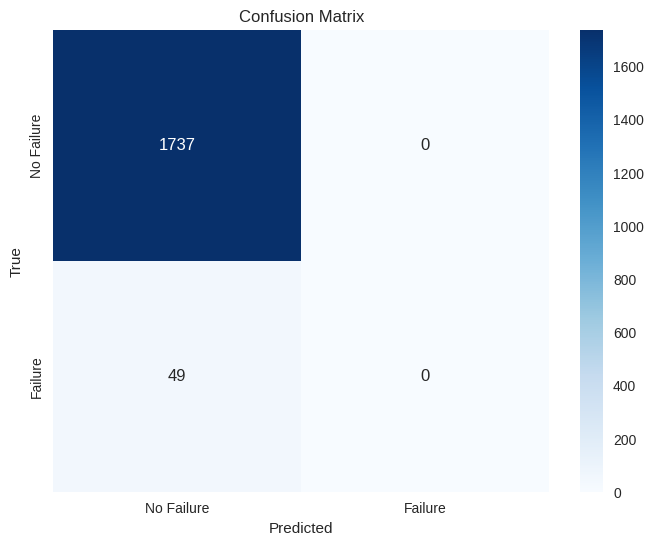

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame for confusion matrix calculation
y_true = predictions.select(label_col).toPandas()[label_col]
y_pred = predictions.select('prediction').toPandas()['prediction']

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualize Confusion Matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Les résultats pour le modèle machine à vecteurs de support (SVM) sont les suivants :  

* **Précision (0.9459)**:
La précision du modèle SVM est de 94,6 %. Cela signifie que, parmi les instances prédites comme positives par le modèle, environ 94,6 % sont réellement des vrais positifs.

* **Rappel (0.9726)** :
le modèle SVM capture efficacement la majorité des instances positives du jeu de données.

* **Score F1 (0.9590)** :
 À 95,9 %, le modèle SVM démontre un équilibre solide entre la capacité à effectuer des prédictions précises positives et à capturer la majorité des instances positives réelles.

* **Exactitude (0.9726)** :
. Avec un score d'exactitude de 97,3 %, le modèle SVM présente une performance globale élevée, indiquant une capacité à bien généraliser aux différentes classes du jeu de données.

* **Temps de traitement** : Le temps d'entraînement relativement long peut être attribué à la complexité du modèle SVM linéaire et à la nature itérative de l'algorithme d'optimisation utilisé pour trouver le plan séparateur optimal. Cependant, il est important de noter que le temps de prédiction reste rapide, ce qui est crucial pour notre application


### **Neural Network Classifier**

In [ ]:
# Define the layers for the neural network
#[input layer size, hidden layer size, output layer size]
layers = [len(train_data.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]), 10, 2]

# Build Neural Network Classifier
nn_classifier = MultilayerPerceptronClassifier(featuresCol="features", labelCol=label_col, layers=layers)

# Create Pipeline
pipeline = Pipeline(stages=[nn_classifier])

# Measure Training Time
start_time = time.time()
model = pipeline.fit(train_data)
end_time = time.time()
training_time = end_time - start_time

print(f"Training Time: {training_time} seconds")

# Make Predictions
start_time = time.time()
predictions = model.transform(test_data)
end_time = time.time()
prediction_time = end_time - start_time

print(f"Prediction Time: {prediction_time} seconds")

Training Time: 0.8303935527801514 seconds
Prediction Time: 0.026976346969604492 seconds


In [ ]:
# Evaluate the Model
evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"Accuracy: {accuracy}")


Precision: 0.9458814921079592
Recall: 0.9725643896976484
F1 Score: 0.9590373800197646
Accuracy: 0.9725643896976484


In [ ]:
# View the results
predictions.select("features", "prediction", label_col).show()

+--------------------+----------+---------------+
|            features|prediction|Machine failure|
+--------------------+----------+---------------+
|[295.5,305.899993...|       0.0|            0.0|
|[295.5,306.0,1326...|       0.0|            0.0|
|[295.5,306.0,1456...|       0.0|            0.0|
|[295.5,306.0,1800...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.600006103515...|       0.0|            0.0|
|[295.700012207031...|       0.0|            0.0|
|[295.700012207031...|       0.0|            0.0|
|[295.700012207031...|       0.0|            0.0|
|[295.799987792968...|       0.0|            0.0|


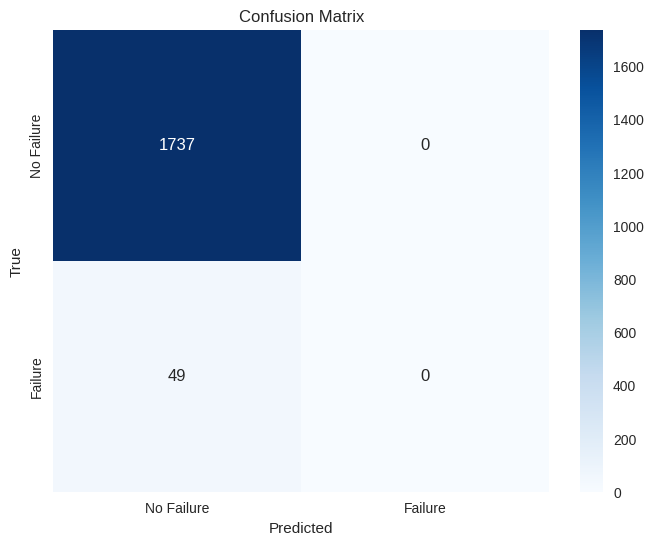

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame for confusion matrix calculation
y_true = predictions.select(label_col).toPandas()[label_col]
y_pred = predictions.select('prediction').toPandas()['prediction']

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualize Confusion Matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Les résultats pour le modèle Neural Network sont les suivants :

* **Précision (Precision)** 94.59% : Environ 94.59% des instances prédites comme positives le sont réellement, indiquant une bonne précision du modèle dans l'identification des cas positifs.

* **Rappel (Recall)** 97.26% :  Indique que le modèle est capable de capturer une grande partie des cas positifs présents dans les données.

* **Score F1 (F1 Score)** 95.90% :  Un score F1 de 95.90% suggère un bon équilibre entre la précision et le rappel du modèle.

* **Exactitude (Accuracy)**97.26% : le modèle a réussi à classifier correctement la grande majorité des instances.

* **Temps de traitement** : Le temps d'entraînement du modèle a été mesuré à 0.814 secondes, ce qui est relativement rapide. Cela suggère que le modèle de réseau de neurones a pu apprendre efficacement à partir des données d'entraînement.Le temps de prédiction du modèle a été mesuré à 0.0284 seconde, indiquant que le modèle peut effectuer des prédictions sur de nouvelles données de manière rapide et efficace.

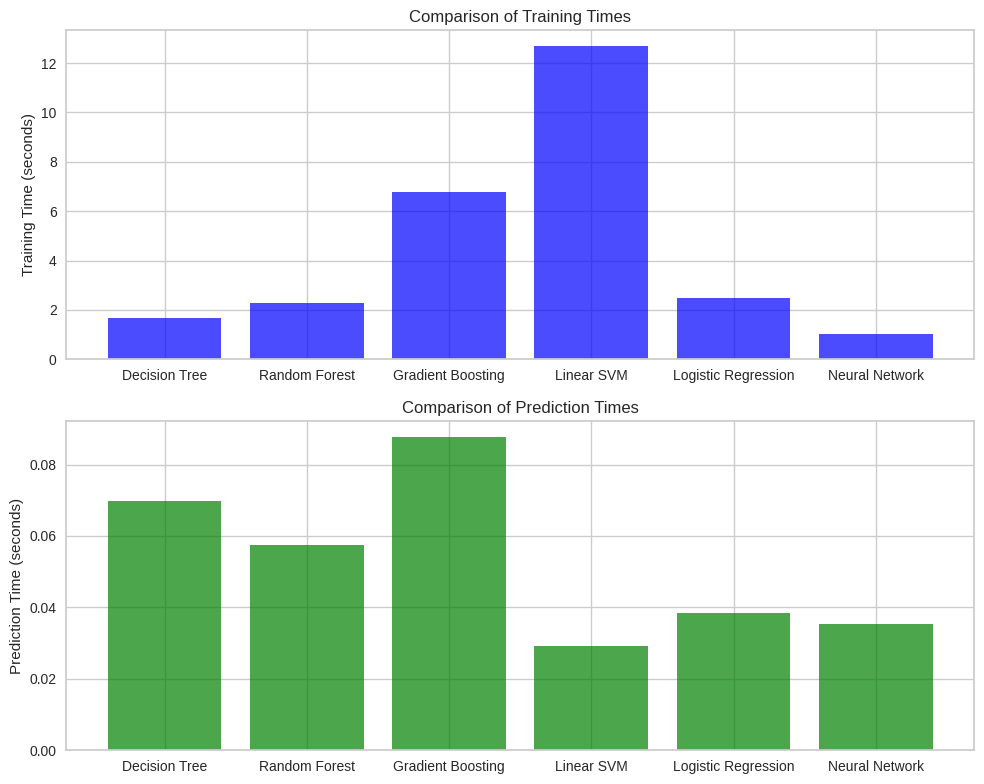

In [ ]:
timing_data = spark.createDataFrame([
    ('Decision Tree', 1.6866776943206787, 0.06988716125488281),
    ('Random Forest', 2.2933573722839355, 0.05749201774597168),
    ('Gradient Boosting', 6.78079080581665,  0.08770418167114258),
    ('Linear SVM', 12.69136118888855 , 0.02920222282409668 ),
    ('Logistic Regression',2.471086025238037 , 0.03834891319274902),
    ('Neural Network',  1.0045897960662842, 0.035447120666503906 )
], ['model', 'training_time', 'prediction_time'])

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = timing_data.toPandas()

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Bar plot for training times
axes[0].bar(pandas_df['model'], pandas_df['training_time'], color='blue', alpha=0.7)
axes[0].set_ylabel('Training Time (seconds)')
axes[0].set_title('Comparison of Training Times')

# Bar plot for prediction times
axes[1].bar(pandas_df['model'], pandas_df['prediction_time'], color='green', alpha=0.7)
axes[1].set_ylabel('Prediction Time (seconds)')
axes[1].set_title('Comparison of Prediction Times')

# Adjust layout
plt.tight_layout()
plt.show()

# Dealing with unbalanced Data

In [ ]:
def balanceDataset(dataset):
    # Calcul du nombre de labels négatifs
    numNegatives = dataset.filter(dataset["Machine failure"] == 0).count()

    # Calcul de la taille du dataset
    datasetSize = dataset.count()

    # Calcul du ratio d'équilibrage
    balancingRatio = (datasetSize - numNegatives) / float(datasetSize)

    # Définition d'une User-Defined Function (UDF) pour calculer les poids
    @udf(returnType=DoubleType())
    def calculateWeights(d):
        if d == 0.0:
            return 1 * balancingRatio
        else:
            return 1 * (1.0 - balancingRatio)

    # Application de l'UDF pour créer une nouvelle colonne "classWeightCol"
    weightedDataset = dataset.withColumn("classWeightCol", calculateWeights(dataset["Machine failure"]))

    return weightedDataset

In [ ]:
# Utilisation de la fonction balanceDataset
balanced_df = balanceDataset(df)

# Affichage du DataFrame équilibré
balanced_df.show()

+----+---------------+-------------------+----------------+------+---------+-------+---------------+--------------------+
|Type|Air temperature|Process temperature|Rotational speed|Torque|Tool wear|  Power|Machine failure|      classWeightCol|
+----+---------------+-------------------+----------------+------+---------+-------+---------------+--------------------+
| 1.0|          298.1|              308.6|          1551.0|  42.8|      0.0|66382.8|            0.0|0.025856496444731737|
| 0.0|          298.2|              308.7|          1408.0|  46.3|      3.0|65190.4|            0.0|0.025856496444731737|
| 0.0|          298.1|              308.5|          1498.0|  49.4|      5.0|74001.2|            0.0|0.025856496444731737|
| 0.0|          298.2|              308.6|          1433.0|  39.5|      7.0|56603.5|            0.0|0.025856496444731737|
| 0.0|          298.2|              308.7|          1408.0|  40.0|      9.0|56320.0|            0.0|0.025856496444731737|
| 1.0|          298.1|  

In [ ]:
# Création d'un assembleur de vecteurs pour regrouper les caractéristiques en un vecteur
feature_columns = [col for col in balanced_df.columns if col != "label" and col != "classWeightCol"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_df = assembler.transform(balanced_df)

# Division de l'ensemble de données en ensembles de formation et de test
(train_data, test_data) = assembled_df.randomSplit([0.8, 0.2], seed=1234)

## Logistic Regression

In [ ]:
# Création du modèle de régression logistique
lr = LogisticRegression(featuresCol="features", labelCol="Machine failure", weightCol="classWeightCol")
# Enregistrement du temps de début de l'entraînement
training_start_time = time.time()
# Entraînement du modèle sur l'ensemble de formation
model = lr.fit(train_data.select("features", "Machine failure", "classWeightCol"))
# Enregistrement du temps d'entraînement
training_end_time = time.time()
training_time = training_end_time - training_start_time
print("Training time:", training_time, "seconds")

# Enregistrement du temps de début de prédiction
prediction_start_time = time.time()

# Faire des prédictions sur l'ensemble de test
predictions = model.transform(test_data)

# Enregistrement du temps de prédiction
prediction_end_time = time.time()
prediction_time = prediction_end_time - prediction_start_time
print("Prediction time:", prediction_time, "seconds")

Training time: 2.248455047607422 seconds
Prediction time: 0.03377509117126465 seconds


In [ ]:
# Évaluation du modèle
evaluator = MulticlassClassificationEvaluator(labelCol="Machine failure", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"Accuracy: {accuracy}")

Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0


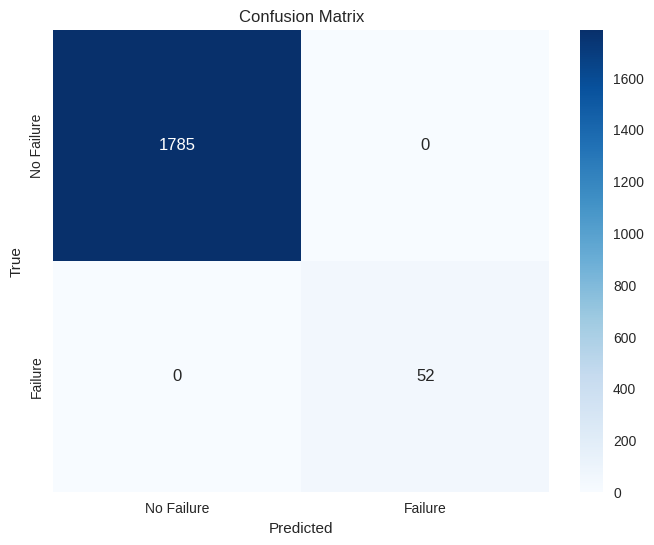

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame for confusion matrix calculation
y_true = predictions.select("Machine failure").toPandas()["Machine failure"]
y_pred = predictions.select("prediction").toPandas()["prediction"]

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualize Confusion Matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## SVM

In [ ]:
# Build Linear SVM Classifier
svm_classifier = LinearSVC(featuresCol="features", labelCol="Machine failure",weightCol="classWeightCol")

# Create Pipeline
pipeline = Pipeline(stages=[svm_classifier])

# Measure Training Time
start_time = time.time()
model = pipeline.fit(train_data.select("features", "Machine failure", "classWeightCol"))
end_time = time.time()
training_time = end_time - start_time

print(f"Training Time: {training_time} seconds")

# Make Predictions
start_time = time.time()
predictions = model.transform(test_data)
end_time = time.time()
prediction_time = end_time - start_time

print(f"Prediction Time: {prediction_time} seconds")


Training Time: 1.7160038948059082 seconds
Prediction Time: 0.02190852165222168 seconds


In [ ]:
# Evaluate the Model
evaluator = MulticlassClassificationEvaluator(labelCol="Machine failure", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"Accuracy: {accuracy}")

Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0


In [ ]:
spark.stop()